<div style="background-color:#800020; 
            color:green; 
            padding:15px; 
            border-radius:10px; 
            text-align:center; 
            font-size:30px; 
            font-weight:bold;">
    Detecting Deep Fakes - A Deep Learning Computer Vision Task<br>
    <span style="font-size:20px; font-weight:normal;">
        Hairy Feet: Anna Attuch, Jakub Jurak, Johannes Degner
    </span>
</div>

# 1. Introduction

Recent advances in generative models have made it increasingly easy to create highly realistic AI-generated images, otherwise known as deepfakes. While these technologies have legitimate applications, they also raise serious ethical and societal concerns, including misinformation, identity misuse, and erosion of trust in visual media. As AI-generated content becomes more difficult to distinguish from real images, reliable automated detection methods are becoming increasingly important.

At the same time, prior work suggests that humans struggle to reliably detect AI-generated images. A study conducted in January 2025 found that human accuracy in distinguishing real from AI-generated images is only around 62% (Roca et al., 2025), slightly above chance. This highlights the need for machine learning approaches that can outperform human-level detection.

The goal of this project is to evaluate whether deep learning models can effectively distinguish real images from AI-generated ones, and to compare how different neural architectures perform on this task. Specifically, we compare three approaches: a custom convolutional neural network (CNN) trained from scratch, a pretrained EfficientNetB0 model using transfer learning, and a Swin 

Transformer model leveraging a transformer-based vision architecture. These models differ in how they process visual information, allowing us to examine how architectural choices affect performance and generalization.

This notebook first introduces the datasets used and describes how they are combined and preprocessed. We then outline the architectures of the three models and motivate key design choices. Finally, we train and evaluate each model on both in-distribution and out-of-distribution test sets to assess detection performance and robustness.


### Table of Contents

**1. Introduction**

**2. Methods**

       2.1 Importing Data

       2.2 Pre-processing Data

       2.3 Data Exploration and Visualisation

       2.4 Neural Models

       2.5 Loss and Performance Metrics

       2.6 Fitting

**3. Results**

       3.1 Loading models

       3.2 Test Set Evaluation

       3.3 Receiver Operating Characteristic (ROC) Curve

       3.4 Accuracy Comparison

       3.5 Performance on Custom Images

**4. Conclusion/Discussion**

**5. References**

**6. Division of Labour**

# 2. Methods

In [50]:
# Importing required packages

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import torch
from torch import nn
from torch.optim import AdamW
from transformers import SwinForImageClassification 
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy
import os
import gc
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


## 2.1 Importing Data
**Data sources**

We use 4 real-versus-AI image datasets to increase diversity and reduce reliance on dataset-specific artifacts. The CIFAKE dataset serves as the main benchmark, while a large 200k real-vs-AI dataset is used to enrich training data. Both these datasets don't include images of faces. Two face-focused datasets are reserved exclusively for out-of-distribution testing to evaluate generalization.


We use Tensorflows built in function `image_dataset_from_directory` to simplify creating our datasets. The datasets are splits into three main categories:
1. Training data
   > A concatonation of the 200k face images dataset and the CiFake dataset consiting of natural images.
3. Hold-out testing data,
   > A hold-out test set from the CiFake dataset
5. Out-of-distribution data
   > A concatonation of two face images datasets which the model has not been trained on

A final dataset is created with contains images of our faces and an deepfake of us.

In [2]:
# Dataset directories

cifake_train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
cifake_test_dir  = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

df20k_dir = "/kaggle/input/deepfake-vs-real-20k/Deep-vs-Real"

hf_dir = "/kaggle/input/human-faces-dataset/Human Faces Dataset"

ds200k_dir = "/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/my_real_vs_ai_dataset/my_real_vs_ai_dataset"

own_data_dir = "/kaggle/input/toy-real-vs-ai-face-test-set/Fun_Data"


In [20]:
########### Helper function for getting dataset #################
def create_ds(directory, subset, labels, IMG_SIZE=(224,224), BATCH_SIZE=None, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=0.2 if subset else None, # Only split if subset is asked for
        subset=subset,
        seed=2025,
        class_names=labels,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=shuffle 
    )
    return ds

########## Training Sets ##########

# CIFAKE 
ds_train_cifake = create_ds(cifake_train_dir, 'training', ['FAKE', 'REAL'])
ds_val_cifake   = create_ds(cifake_train_dir, 'validation', ['FAKE', 'REAL'])

ds_train_cifake = ds_train_cifake.apply(tf.data.experimental.ignore_errors()) # Because it has corrupted files that crash the system otherwise

# 200K Dataset
ds_train_200k = create_ds(ds200k_dir, 'training', ['ai_images', 'real'])
ds_val_200k   = create_ds(ds200k_dir, 'validation', ['ai_images', 'real'])

# CIFAKE hold-out set
ds_test_cifake = create_ds(cifake_test_dir, None, ['FAKE', 'REAL'], shuffle = False)

######### Out-of-Distribution (face) sets ########

# Deepfake 20k
ds_ood_df20k = create_ds(df20k_dir, None, ['Deepfake', 'Real'], shuffle = False)

# HF Dataset 
ds_ood_hf = create_ds(hf_dir, None , ['AI-Generated Images', 'Real Images'], shuffle = False)

#  Concatenate both OOD datasets
ds_ood_combined = ds_ood_df20k.concatenate(ds_ood_hf)

# Our own pictures
own_data = create_ds(own_data_dir, None , ['AI', 'Real'], shuffle = False)

print("Datasets created!")

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Found 200000 files belonging to 2 classes.
Using 160000 files for training.
Found 200000 files belonging to 2 classes.
Using 40000 files for validation.
Found 20000 files belonging to 2 classes.
Found 19219 files belonging to 2 classes.
Found 9630 files belonging to 2 classes.
Found 4 files belonging to 2 classes.
Datasets created!


## 2.2 Pre-processing Data 
The data are forced into `(224, 224, 3)` to ensure smooth training and predictions for the models. Furthermore, they're separated into batches of 64 images. Finally, the datasets are autotuned using `tf.data.autotune` to optimize CPU and GPU allocation and training. 

In [21]:
# Define a helper to enforce shapes
def force_shape(image, label):
    # Explicitly set the shape. This converts RaggedTensors to Dense Tensors.
    image = tf.ensure_shape(image, (224, 224, 3))
    label = tf.ensure_shape(label, ())
    return image, label

# Full dataset function
def ds_full(datasets, weights, batch_size = 64):
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds_full = tf.data.Dataset.sample_from_datasets(
        datasets,
        weights=weights,
        stop_on_empty_dataset=False
    )
 
    #ds_full = ds_full.unbatch() # Safety check to stop code from crashing if cell is run twice
    
    ds_full = ds_full.map(force_shape, num_parallel_calls=tf.data.AUTOTUNE)

    ds_full = ds_full.shuffle(buffer_size=1000)
    ds_full = ds_full.batch(batch_size)
    ds_full = ds_full.prefetch(tf.data.AUTOTUNE)

    return ds_full

# Test set function
def prepare_test_set(ds, batch_size=64):
    AUTOTUNE = tf.data.AUTOTUNE

    #ds = ds.unbatch() # Safety check to stop code from crashing if cell is run twice
    
    ds = ds.map(force_shape, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(AUTOTUNE)
    
    return ds

# Full training set
ds_train_full = ds_full([ds_train_cifake, ds_train_200k], [1.0, 1.0])
print("Train Dataset Created!")

# Full validation set
ds_val_full = ds_full([ds_val_cifake, ds_val_200k], [1.0, 1.0])
print("Validation Dataset Created!")

# Hold-out Test set
ds_test_cifake = prepare_test_set(ds_test_cifake)

# OOD Test set
ds_test_ood = prepare_test_set(ds_ood_combined)
print("Test Datasets Created!")

# Own photo dataset
ds_own_photos = prepare_test_set(own_data)
print("Own Photos Dataset Created!")

Train Dataset Created!
Validation Dataset Created!
Test Datasets Created!
Own Photos Dataset Created!


## 2.3 Data Exploration and Visualisation
We visualize sample images by creating a helper function that takes a random batch and plots 6 images with their corresponding labels.

Showing random samples also helps us get an intuitive understanding of what the model will see during training and whether the dataset contains sufficient visual variability for effective learning.

For the training set, we can see that it consists of both face images and natural images. However, the natural images are pixalated as they come from the CiFake dataset which contains 32*32 sized images. 

Since the OOD test set is not shuffled we cannot get random samples of different labels, yet we can still see that the deepfakes are of high quality, providing a strong generalizability test for our models.

--- CIFAKE Training ---


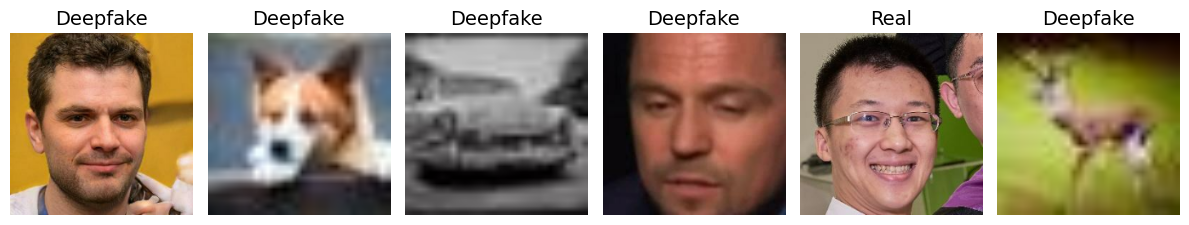

--- OOD Data ---


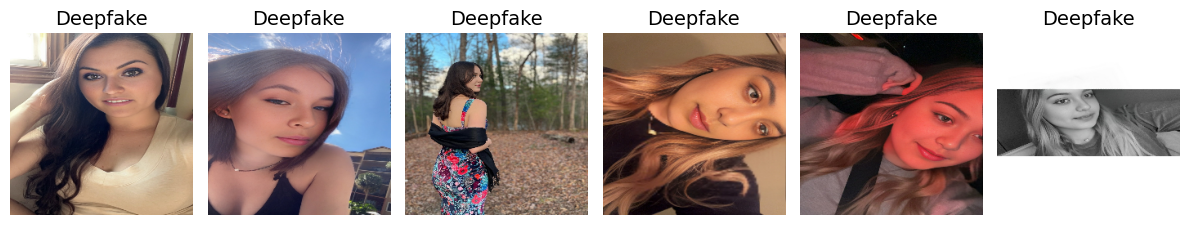

--- Own Photos ---


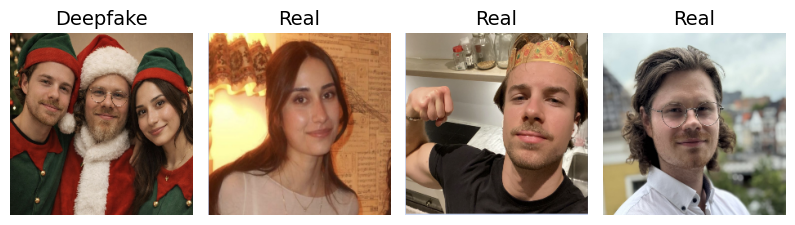

In [44]:
# Helper function for showing the images
def show_image(dataset):
    """
    Plots 3 images from the dataset.
    Assumes standard labeling: 0 = Deepfake/AI, 1 = Real.
    """
    # Standardized class names for all your datasets
    class_names = ['Deepfake', 'Real']

    # Take one batch
    for images, labels in dataset.take(1):
        plt.figure(figsize=(12, 4)) # Adjusted size for a 1x3 row
        
        # Determine how many images to plot (max 6)
        num_to_plot = min(6, images.shape[0])
        
        for i in range(num_to_plot):
            ax = plt.subplot(1, 6, i + 1) # 1 row, 3 columns
            
            # Convert tensor to numpy
            img = images[i].numpy()
            
            # Fix display range if needed (convert 0-255 or 0-1)
            if img.max() > 1.0:
                img = img.astype("uint8")
                
            plt.imshow(img)
            
            # Map the integer label (0 or 1) to "Deepfake" or "Real"
            label_index = int(labels[i])
            
            # Safety check in case a label is unexpected
            if label_index < len(class_names):
                name = class_names[label_index]
            else:
                name = f"Label {label_index}"
                
            plt.title(name, fontsize=14)
            plt.axis("off")
            
        plt.tight_layout()
        plt.show()

# Show
print("--- CIFAKE Training ---")
show_image(ds_train_full)

print("--- OOD Data ---")
show_image(ds_test_ood)

print("--- Own Photos ---")
show_image(ds_own_photos)

## 2.4 Neural Models

### 2.4.1 Custom CNN
For the first model, we build a custom CNN using `keras.Sequential`. This model consists of an initial data augmentation block, four convolution + pooling blocks (apart from block 4), global average pooling, and a final fully-connected classifier block with a 50% dropout layer to combat overfitting. 

**Architecture**

In [24]:
# Custom-made CNN classifier 
custom_cnn = keras.Sequential([
    # Input layer
    layers.Input(shape=(224, 224, 3)),

    # Data Augmentation
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
    # First convolution + maxpool block (32 filters)
    layers.Conv2D(filters=32, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Second convolution + maxpool block (64 filters)
    layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Third convolution + maxpool block (128 filters)
    layers.Conv2D(filters=128, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    #Fourth convolution + maxpool block (256 filters)
    layers.Conv2D(filters=256, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),
    # removed maxpool to preserve fine-grained details

    # Global average pooling block
    layers.GlobalAveragePooling2D(),

    # Fully connected block
    layers.Dense(128, activation='relu'), # only one layer with high dropout to fight overfitting
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
    
])

# Setting up the optimizer and performance metrics
custom_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Slower, more precise training
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Plotting the model architecture 
custom_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           12

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

### 2.4.2 Pre-trained CNN
For the pre-trained CNN, we use the EfficientNet baseline network `EfficientNetB0` as our backbone. We first augment the data exactly like in the custom CNN, then run this through the frozen backbone, and finally we attach a custom classifier block for training. 

**Architecture**



In [25]:
IMG_SIZE = 224

# Same data augmentation as for the custom CNN
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Load pretrained EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Freeze weights

# Build the final Model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Data augmentation applies ONLY during training
x = data_augmentation(inputs) 

# Preprocessing of pixel values to prevent any data structure differences
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Run through the frozen base
x = base_model(x, training=False) # Keep BatchNormalization layers in inference mode

# Classifier head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_cnn = models.Model(inputs, outputs)

# Setting up the optimizer and performance metrics
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# Plotting the model architecture
model_cnn.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 2.4.3 Visual Transformer
For the visual transformer we had to change from `Tensorflow` to `PyTorch`. Getting help from Google Gemini, we created a visual transformer classifier class using the Microsoft Swin Transformer as our frozen backbone, to which we attached a custom classifier head for training. 

Since transformers take a long time to train, we added further augmentation to the class and training to optimize GPU and VRAM usage. 

**Architecture**

In [26]:

# Enable faster TF GPU memory allocation
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

class SwinClassifier:
    def __init__(self, model_name="microsoft/swin-tiny-patch4-window7-224", num_labels=1, learning_rate=2e-5):
        """
        Initializes the Swin Transformer.
        Defaults to Swin-Tiny (28M params) for efficiency.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f" Initializing SwinClassifier on {self.device}...")

        # Load Model
        self.model = SwinForImageClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        ).to(self.device)

        
        # Weight freezing of the Swin backbone
        for param in self.model.swin.parameters():
            param.requires_grad = False
            
        # Ensure the Classifier Head is OPEN for training
        for param in self.model.classifier.parameters():
            param.requires_grad = True

        # Compile (Optional Speedup for P100/T4 GPUs)
        try:
            self.model = torch.compile(self.model)
        except:
            pass

        # Optimization
        trainable_params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = AdamW(trainable_params, lr=learning_rate)
        
        # CHANGED: Use BCEWithLogitsLoss for Binary Classification (1 neuron)
        # This is more numerically stable than CrossEntropy for 2 classes.
        self.criterion = nn.BCEWithLogitsLoss()
        self.scaler = torch.amp.GradScaler('cuda')

        self.history = {
            'loss': [], 'accuracy': [],
            'val_loss': [], 'val_accuracy': []
        }

    def _tf_to_torch_fast(self, images, labels):
        """
        Internal helper: Optimized data transfer from TF (CPU) -> PyTorch (GPU).
        """
        images = torch.from_numpy(np.array(images)) 
        
        # CHANGED: Convert labels to float and add dimension for BCE Loss
        # Input: [0, 1, 0] -> Output: [[0.0], [1.0], [0.0]]
        labels = torch.from_numpy(np.array(labels)).float().to(self.device)
        labels = labels.unsqueeze(1) 

        images = images.to(self.device, non_blocking=True)
        # Swin expects [Batch, Channel, Height, Width]
        images = images.permute(0, 3, 1, 2).float() / 255.0
        
        return images, labels

    def _validate(self, val_loader):
        """Internal helper for validation loop"""
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = self._tf_to_torch_fast(images, labels)
                
                with torch.amp.autocast('cuda'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs.logits, labels)
                
                val_loss += loss.item() * labels.size(0)
                
                # Binary Accuracy (Sigmoid > 0.5)
                probs = torch.sigmoid(outputs.logits)
                preds = (probs > 0.5).float()
                
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        if total == 0: return 0.0, 0.0
        return val_loss / total, correct / total

    def train(self, train_ds, val_ds, epochs=10, patience=3):
        """
        Main training loop with Swin-specific adjustments.
        """
        try:
            n_batches = len(train_ds)
        except:
            n_batches = None

        train_loader = tfds.as_numpy(train_ds)
        val_loader = tfds.as_numpy(val_ds)
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_weights = None
        
        print(f"\n Starting Swin Training (Max Epochs: {epochs}, Patience: {patience})")

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            with tqdm(train_loader, total=n_batches, unit="batch", leave=True) as pbar:
                pbar.set_description(f"Epoch {epoch+1}/{epochs}")
                
                for batch_idx, (images, labels) in enumerate(pbar):
                    images, labels = self._tf_to_torch_fast(images, labels)
                    
                    self.optimizer.zero_grad()
                    
                    # Mixed Precision Forward
                    with torch.amp.autocast('cuda'):
                        outputs = self.model(images)
                        loss = self.criterion(outputs.logits, labels)
                    
                    # Mixed Precision Backward
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()

                    # Metrics
                    batch_size = labels.size(0)
                    running_loss += loss.item() * batch_size
                    
                    # Binary Accuracy
                    probs = torch.sigmoid(outputs.logits)
                    preds = (probs > 0.5).float()
                    
                    correct += (preds == labels).sum().item()
                    total += batch_size
                    
                    # Live Update
                    current_acc = correct / total
                    current_loss = running_loss / total
                    pbar.set_postfix({"loss": f"{current_loss:.4f}", "acc": f"{current_acc:.4f}"})

            # Validation
            val_loss, val_acc = self._validate(val_loader)
            
            self.history['loss'].append(current_loss)
            self.history['accuracy'].append(current_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_acc)
            
            print(f"    Validation - loss: {val_loss:.4f} - acc: {val_acc:.4f}")

            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_weights = copy.deepcopy(self.model.state_dict())
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\n Early stopping triggered! Restoring best weights.")
                    self.model.load_state_dict(best_model_weights)
                    break
        
        if best_model_weights is not None and patience_counter < patience:
             self.model.load_state_dict(best_model_weights)

    def plot_history(self):
        """Plots accuracy and loss graphs."""
        if not self.history['loss']:
            print("No training history to plot.")
            return

        epochs_range = range(1, len(self.history['loss']) + 1)
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.history['loss'], 'bo-', label='Training Loss')
        plt.plot(epochs_range, self.history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.history['accuracy'], 'bo-', label='Training Acc')
        plt.plot(epochs_range, self.history['val_accuracy'], 'r-', label='Validation Acc')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def predict(self, tf_dataset):
        """Returns predictions for the dataset."""
        loader = tfds.as_numpy(tf_dataset)
        self.model.eval()
        
        all_preds = []
        all_labels = []
        
        print(f" Running Prediction...")
        with torch.no_grad():
            for images, labels in tqdm(loader, unit="batch"):
                images, labels = self._tf_to_torch_fast(images, labels)
                
                with torch.amp.autocast('cuda'):
                    outputs = self.model(images)
                
                # CHANGED: Sigmoid for Binary Probabilities
                probs = torch.sigmoid(outputs.logits)
                
                all_preds.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
                
        return np.concatenate(all_labels), np.concatenate(all_preds)

    def save(self, path="swin_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f" Model saved to: {path}")

    def load(self, path="swin_model.pth"):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()
        print(f" Model loaded from: {path}")

## 2.5 Loss and Performance Metrics

1. Loss
   > For every model we used the Adam optimizer (Adaptive Moment Estimation) for reducing loss during training.
   > All models are trained using binary cross-entropy loss, which is appropriate for binary classification tasks like distinguishing real images from AI-generated images. This loss function measures how well the predicted probabilities align with the true class labels and provides stable gradients for training neural networks.
2. Performance Metrics
   > Model performance is evaluated using classification accuracy and Receiver Operating Characteristic (ROC) curves. Accuracy provides an intuitive measure of the proportion of correctly classified images and allows direct comparison across models and against reported human-level detection performance. However, accuracy alone can be sensitive to decision thresholds.
    > To complement this, we also use ROC curves, which visualize the trade-off between true positive rate and false positive rate across all possible classification thresholds. The Area Under the ROC Curve (AUC) serves as a threshold-independent measure of separability between real and AI-generated images. Together, accuracy and ROC/AUC provide a more complete assessment of model performance and robustness.
   




## 2.6 Fitting


### 2.6.1 Early Stopping for keras models
Early stopping was implemented for the training of the `Keras` models. This helps in preventing overfitting and restoring the best weights found during training. 

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=3,                
    restore_best_weights=True, 
    verbose=1                  
)

### 2.6.2 Function for training, predicting and cleaning for keras models
This helper function was created with the help of Google Gemini. It does the following:
1. Trains the selected model on a training set and validation set
2. Plots the accuracy and loss plots of the training history.
3. Evaluates the trained model on given test datasets and saves the accuracies in a dictionary
4. Saves the trained model to your disk
5. Scrubs the GPU's VRAM to prevent an out-of-memory error during subsequent training. 

In [30]:

# Initialize the global results dictionary if it doesn't exist
if 'all_results' not in globals():
    all_results = {}

# Define your test sets map
test_sets = {
    "CIFAKE_Test": ds_test_cifake,
    "OOD_Test":    ds_test_ood
}

def train_eval_clean(model, model_name, train_ds, val_ds, test_sets, epochs=30):
    """
    1. Trains the model.
    2. PLOTS the history (New Step).
    3. Evaluates on all test/OOD sets.
    4. Saves results to global 'all_results'.
    5. Saves model to disk.
    6. Deletes model and clears VRAM.
    """
    print(f"\n{'='*60}")
    print(f" STARTING PIPELINE FOR: {model_name}")
    print(f"{'='*60}")

    # Train
    print(f" Training {model_name}...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping] # Assumes 'early_stopping' is defined globally
    )

    # Plot history
    print(f" Plotting training history for {model_name}...")
    
    # Convert history to pandas DataFrame
    history_frame = pd.DataFrame(history.history)
    
    # Plot Loss
    history_frame.loc[:, ['loss', 'val_loss']].plot(title=f"{model_name} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show() 
    
    # Plot Accuracy
    acc_key = 'binary_accuracy' if 'binary_accuracy' in history_frame.columns else 'accuracy'
    val_acc_key = f'val_{acc_key}'
    
    if acc_key in history_frame.columns:
        history_frame.loc[:, [acc_key, val_acc_key]].plot(title=f"{model_name} - Accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()

    # Evaluate
    print(f"\n Evaluating {model_name} on {len(test_sets)} datasets...")
    
    # Create entry in global results dict
    all_results[model_name] = {}

    for ds_name, ds in test_sets.items():
        print(f"   • Predicting on {ds_name}...")
        
        # Predict
        preds = model.predict(ds, verbose=0) 
        
        # Handle shapes: (N, 2) -> (N,) or (N, 1) -> (N,)
        if preds.shape[-1] > 1:
            y_pred = preds[:, 1] 
        else:
            y_pred = preds.flatten()
            
        # Get True Labels
        y_true = np.concatenate([y for x, y in ds], axis=0)
        
        # Store
        all_results[model_name][ds_name] = {
            'y_pred': y_pred,
            'y_true': y_true
        }

    # Save to disk
    filename = f"{model_name}_final.keras"
    model.save(filename)
    print(f"\n Model saved to: {filename}")

    
    # Clean-up of VRAM to prevent OOM issue when training models back to back
    print(f"🧹 Scrubbing VRAM...")
    del model
    tf.keras.backend.clear_session()
    gc.collect()
    print(f" {model_name} pipeline complete. GPU is ready for next model.\n")
    
    return history

### 2.6.2 Custom CNN

In [ ]:
# Training/evaluating/saving the custom CNN
hist_custom = train_eval_clean(
    custom_cnn, 
    "Custom_CNN", 
    ds_train_full, 
    ds_val_full, 
    test_sets,
    epochs=20 # Kept at 20 to allow for early stopping to recover best weights
)

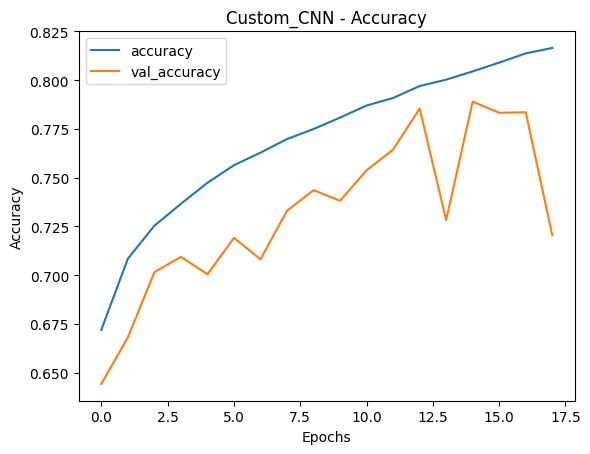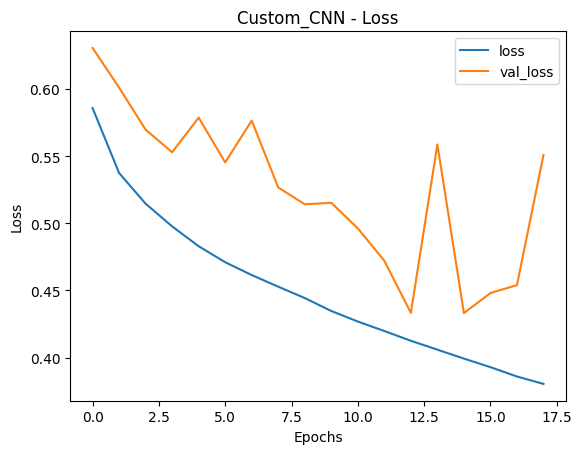

**The custom CNN shows clears signs of overfitting as the validation loss is consistently above the training loss. Furthermore, there are signs of instability as both the validation loss and accuracy are jagged.**

### 2.6.3 Pre-trained CNN

In [ ]:
# Training/evaluating/saving the Pre-trained CNN
hist_cnn = train_eval_clean(
    model_cnn, 
    "Pretrained_CNN", 
    ds_train_full, 
    ds_val_full, 
    test_sets,
    epochs=10 # Kept at 10 to cut down on training time
)


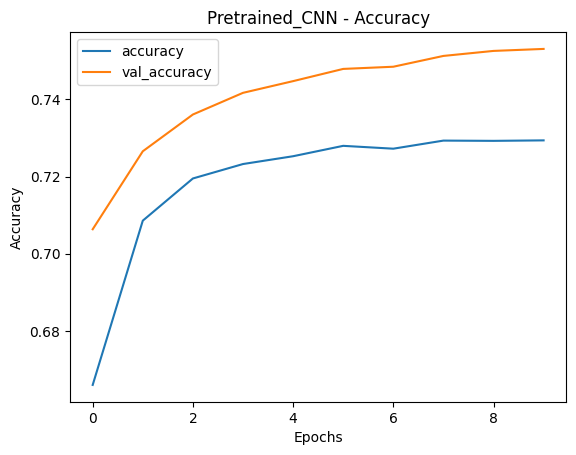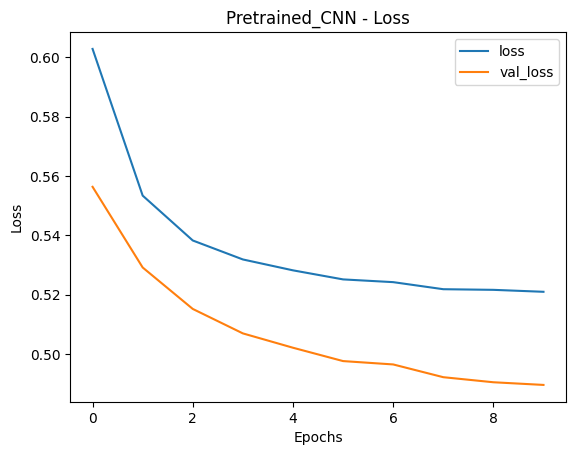

**The pretrained CNN shows good convergence, with a quick learning and stabilization. Potentially the model is underfit and could have been trained for several more epochs as the validation loss is still below training loss.**

### 2.6.3 Visual Transformer

In [ ]:
# Initialize Swin
swin_model = SwinClassifier(num_labels=1) 

# Train 
swin_model.train(ds_train_full, ds_val_full, epochs=10, patience=3)

# Plot
swin_model.plot_history()

# Saving the model
swin_model.save("Swin_Transformer.pth")

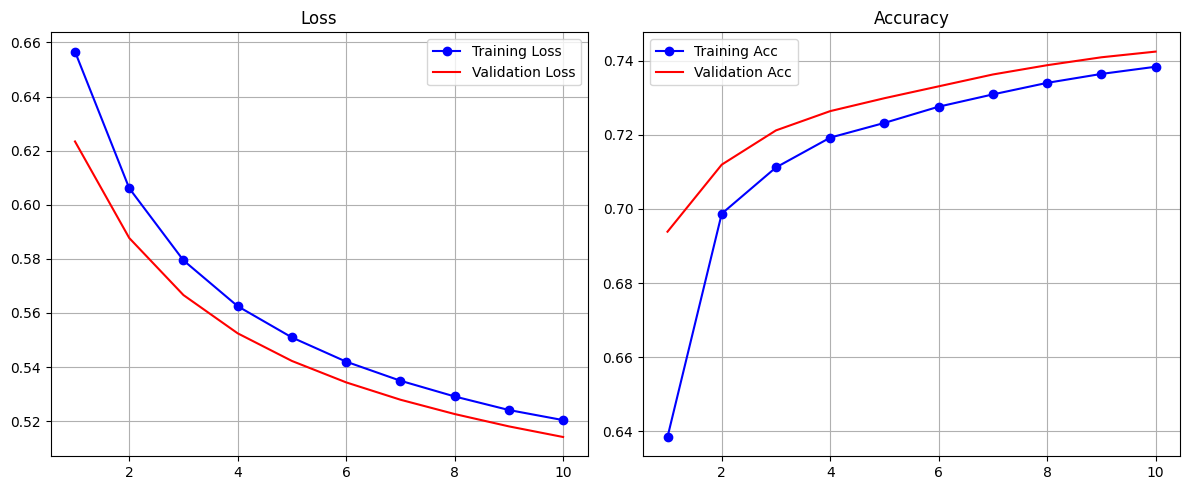

**Similarly to the pretrained CNN, the Swin Transformer shows good convergence, with a quick learning and stabilization. Again, potentially the model is underfit and could have been trained for several more epochs as the validation loss is still below training loss.**

# 3. Results

## 3.1 Loading models
The individual models took a long time to train, so this was done in a seperate notebook for each model to parallelize the training and speed things up. Therefore, they have to be loaded back in with their trained weights.

In [31]:
#The paths to the different trained models 

custom_cnn_path = "/kaggle/input/custom-cnn/tensorflow2/default/1/Custom_CNN_final.keras"

pretrained_cnn_path = "/kaggle/input/pre-trained-cnn/tensorflow2/default/1/Pretrained_CNN_final.keras"

swin_transformer_path = "/kaggle/input/swin-model/pytorch/default/1/Swin_Tiny_Frozen_Final.pth"

# Loading the Tensorflow (.keras) models
custom_cnn_model = tf.keras.models.load_model(custom_cnn_path)
pre_trained_model = tf.keras.models.load_model(pretrained_cnn_path)

# Loading the PyTorch (.pth) model
swin_model = SwinClassifier(num_labels=1)

swin_model.load(swin_transformer_path)

print("Models Loaded in!")

🔧 Initializing SwinClassifier on cuda...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded from: /kaggle/input/swin-model/pytorch/default/1/Swin_Tiny_Frozen_Final.pth
Models Loaded in!


## 3.2 Test Set Evaluation
All the models are evaluated (i.e., `.evaluate()`) to get accuracy metrics and predicted (i.e., `.predict()`) to get probabilities/predicted-labels.

### 3.2.1 Keras Models (Custom CNN and Pretrained CNN)

In [46]:
# Helper function for probabilities and labels
def prob_and_label(model, dataset):
    probs = model.predict(dataset),
    labels = np.concatenate([y for x, y in dataset], axis=0)

    return probs, labels

# Custom CNN

# Evaluate to get accuracies
custom_cnn_test = custom_cnn_model.evaluate(ds_test_cifake)
custom_cnn_ood = custom_cnn_model.evaluate(ds_test_ood)
print('Custom CNN Evaluated!')

# Predictions
custom_cnn_test_predictions = prob_and_label(custom_cnn_model, ds_test_cifake)
custom_cnn_ood_predictions = prob_and_label(custom_cnn_model, ds_test_ood)
print('Custom CNN Predicted!')

# Pre-trained CNN

# Evaluate to get accuracies
pre_trained_test = pre_trained_model.evaluate(ds_test_cifake)
pre_trained_ood = pre_trained_model.evaluate(ds_test_ood)
print('Pretrained CNN Evaluated!')

# Predictions
pretrained_cnn_test_predictions = prob_and_label(pre_trained_model, ds_test_cifake)
pretrained_cnn_ood_predictions = prob_and_label(pre_trained_model, ds_test_ood)
print('Pretrained CNN Predicted!')

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9099 - loss: 0.2332
240/451 ━━━━━━━━━━━━━━━━━━━━ 1:25 405ms/step - accuracy: 0.1103 - loss: 2.3084

Invalid SOS parameters for sequential JPEG


451/451 ━━━━━━━━━━━━━━━━━━━━ 135s 299ms/step - accuracy: 0.2902 - loss: 1.8370
Custom CNN Evaluated!
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step
240/451 ━━━━━━━━━━━━━━━━━━━━ 1:24 399ms/step

Invalid SOS parameters for sequential JPEG


451/451 ━━━━━━━━━━━━━━━━━━━━ 133s 295ms/step


Invalid SOS parameters for sequential JPEG


Custom CNN Predicted!
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.8311 - loss: 0.3881
240/451 ━━━━━━━━━━━━━━━━━━━━ 1:26 408ms/step - accuracy: 0.2912 - loss: 1.2542

Invalid SOS parameters for sequential JPEG


451/451 ━━━━━━━━━━━━━━━━━━━━ 148s 328ms/step - accuracy: 0.3959 - loss: 1.0775
Pretrained CNN Evaluated!
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 142ms/step
240/451 ━━━━━━━━━━━━━━━━━━━━ 1:26 409ms/step

Invalid SOS parameters for sequential JPEG


451/451 ━━━━━━━━━━━━━━━━━━━━ 148s 327ms/step


Invalid SOS parameters for sequential JPEG


Pretrained CNN Predicted!


### 3.2.2 PyTorch Model (Swin Transformer)

In [48]:
# Test set evaluation helper function 
def evaluate_swin(name, dataset):
    print(f" Predicting {name}...")
    
    # Get predictions
    true_labels, probabilities = swin_model.predict(dataset)
    predictions = (probabilities > 0.5).astype(int)
    
    # Calculate Metrics
    acc = accuracy_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions)
    
    return acc, cm, true_labels, probabilities

# Swin Transformer
swin_test = evaluate_swin("Swin CIFAKE Test", ds_test_cifake)
swin_ood = evaluate_swin("Swin OOD Test", ds_test_ood)

print("Swin Evaluated!")

 Predicting Swin CIFAKE Test...
 Running Prediction...


  0%|          | 0/313 [00:00<?, ?batch/s]

 Predicting Swin OOD Test...
 Running Prediction...


  0%|          | 0/451 [00:00<?, ?batch/s]

Invalid SOS parameters for sequential JPEG


Swin Evaluated!


## 3.3 Receiver Operating Characteristic (ROC) Curve
The ROC Curve is a diagnostic plot that evaluates the performance of a classification model at all classification thresholds, rather than just a single cutoff (like 0.5). It visualizes the trade-off between sensitivity (catching positive cases) and specificity (avoiding false alarms).

Key Metric: AUC (Area Under the Curve) The AUC represents the probability that the model will rank a random positive example higher than a random negative example.

> AUC = 1.0: Perfect Classifier (distinguishes classes perfectly).

> AUC = 0.5: Random Guessing (no discriminative power).

> AUC < 0.5: Worse than random (predicting the opposite).

Visual Interpretation:

> Top-Left Corner: The ideal curve hugs the top-left corner, indicating high recall with very few false alarms.

> Diagonal Line: A line from (0,0) to (1,1) represents a model that is guessing randomly.

> Steepness: A steep rise at the beginning indicates the model is very good at identifying "easy" positives without making mistakes.

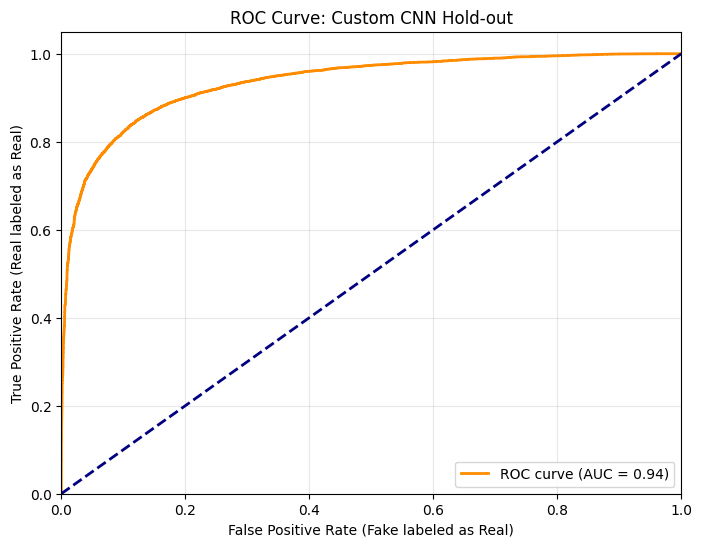

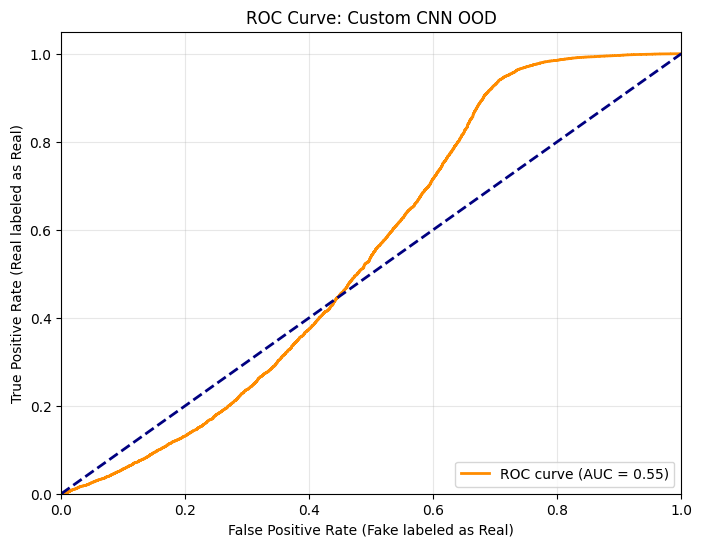

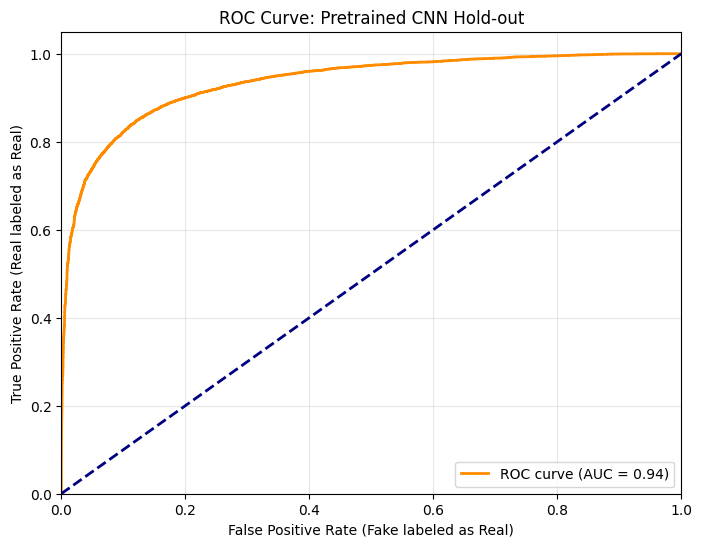

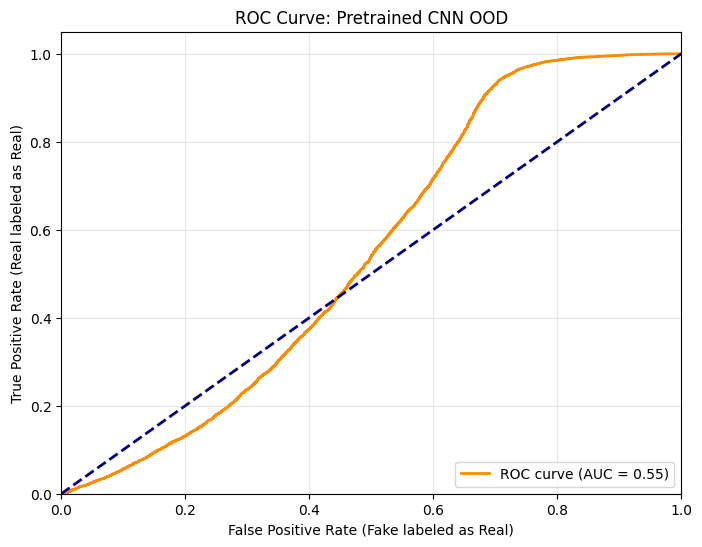

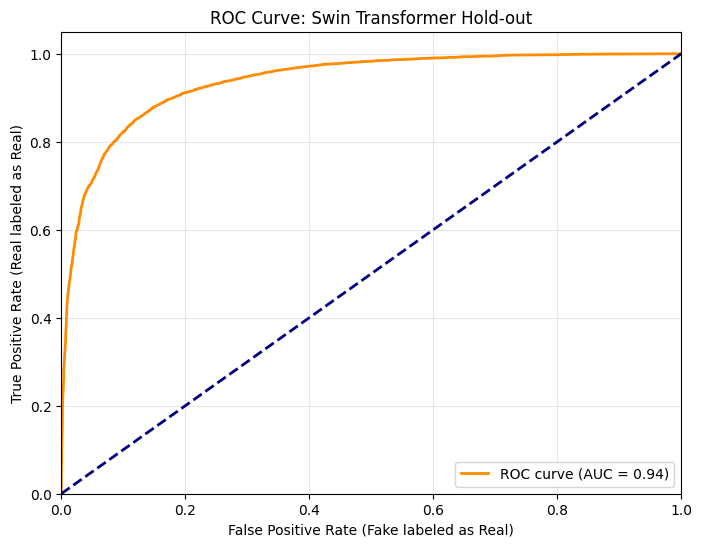

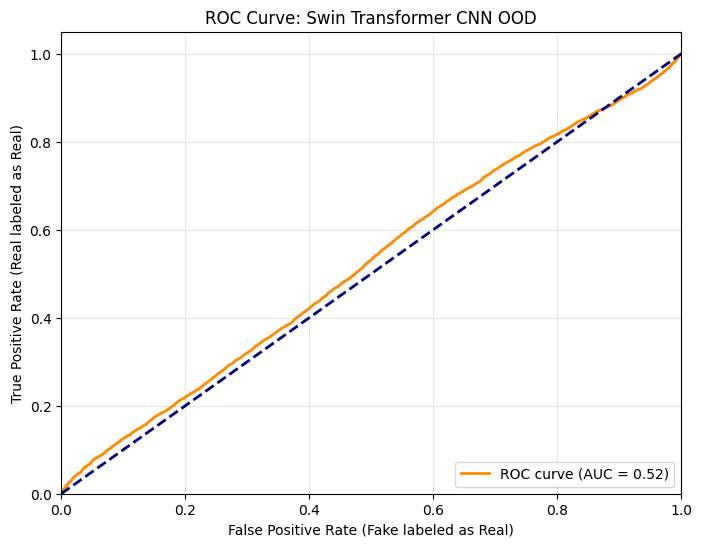

In [54]:
def plot_roc_curve(y_true, y_pred, title="ROC Curve"):
    """
    Calculates and plots the ROC curve and AUC score.
    """
    # 1. Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    # 2. Calculate Area Under Curve (AUC)
    roc_auc = auc(fpr, tpr)
    
    # 3. Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Fake labeled as Real)')
    plt.ylabel('True Positive Rate (Real labeled as Real)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Custom CNN ROC
plot_roc_curve(custom_cnn_test_predictions[1],custom_cnn_test_predictions[0][0], title = 'ROC Curve: Custom CNN Hold-out')
plot_roc_curve(custom_cnn_ood_predictions[1],custom_cnn_ood_predictions[0][0], title = 'ROC Curve: Custom CNN OOD')

# Pre-trained CNN ROC
plot_roc_curve(pretrained_cnn_test_predictions[1],custom_cnn_test_predictions[0][0], title = 'ROC Curve: Pretrained CNN Hold-out')
plot_roc_curve(pretrained_cnn_ood_predictions[1],custom_cnn_ood_predictions[0][0], title = 'ROC Curve: Pretrained CNN OOD')

# Swin Transformer ROC
plot_roc_curve(swin_test[2],swin_test[3], title = 'ROC Curve: Swin Transformer Hold-out')
plot_roc_curve(swin_ood[2],swin_ood[3], title = 'ROC Curve: Swin Transformer CNN OOD')


**Based on the ROC curves, we can conclude that the models all perform very strongly on the hold-out test set, however they all are performing at practically guessing level for the OOD test set**

## 3.4 Accuracy Comparison
The accuracy gives us an understanding of how well the models do in comparison to each other with a classical (>0.5) classification cutoff. In typical ML fashion, we want a model that achives the highest accuracy and also had a strong OOD accuracy. 


In [55]:
# Dictionary of the accuracy from each evaluation tuple
acc_dict = {
    "Custom CNN CiFake": custom_cnn_test[1],
    "Custom CNN OOD" : custom_cnn_ood[1],
    "Pre-trained CNN CiFake": pre_trained_test[1],
    "Pre-trained CNN OOD": pre_trained_ood[1],
    "Swin Transformer CiFake": swin_test[0],
    "Swin Transformer OOD": swin_ood[0]
}

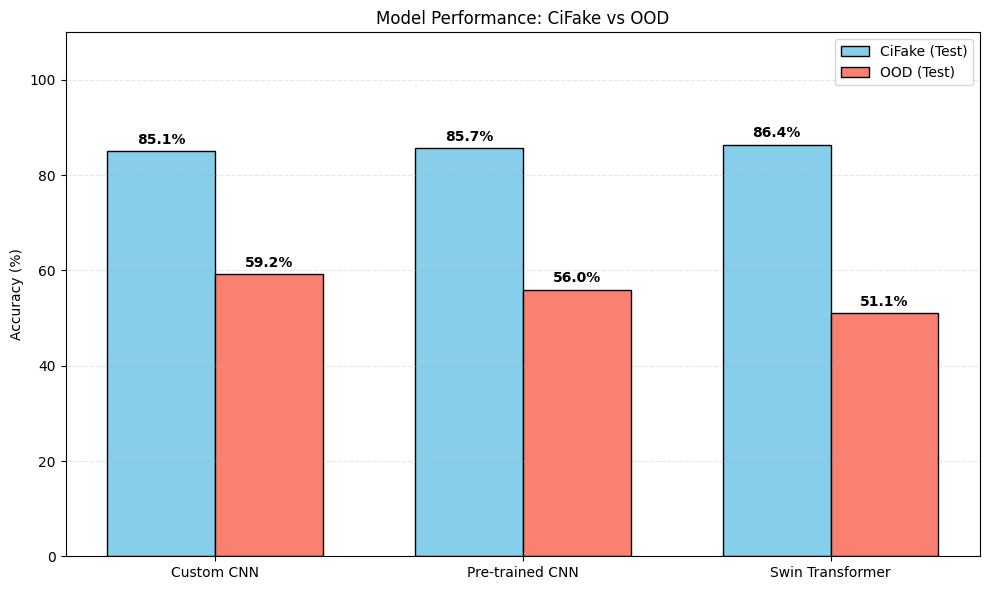

In [56]:
# Extract Data
models = ['Custom CNN', 'Pre-trained CNN', 'Swin Transformer']
cifake_scores = [acc_dict["Custom CNN CiFake"], acc_dict["Pre-trained CNN CiFake"], acc_dict["Swin Transformer CiFake"]]
ood_scores = [acc_dict["Custom CNN OOD"], acc_dict["Pre-trained CNN OOD"], acc_dict["Swin Transformer OOD"]]

# Convert to percentages
cifake_scores = [x * 100 for x in cifake_scores]
ood_scores = [x * 100 for x in ood_scores]

# Setup Plot
x = np.arange(len(models))
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cifake_scores, width, label='CiFake (Test)', color='skyblue', edgecolor='black')
rects2 = ax.bar(x + width/2, ood_scores, width, label='OOD (Test)', color='salmon', edgecolor='black')

# Styling
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Performance: CiFake vs OOD')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 110) 
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Helper function to put text on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

## 3.5 Performance on Custom Images 
Just for fun, and per request of Gustaw, we also wanted to see how well the models do at evaluating images of us and one Deepfake of us. 

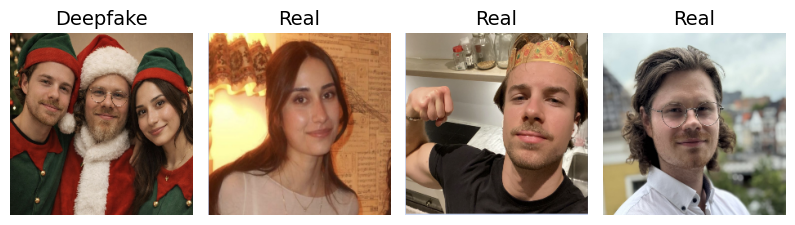

 Running Prediction...


  0%|          | 0/1 [00:00<?, ?batch/s]

Final Predictions
Custom CNN:       ['Real', 'Real', 'Real', 'Real']
Pre-trained CNN:  ['Real', 'Deepfake', 'Real', 'Deepfake']
Swin Transformer: ['Deepfake', 'Real', 'Real', 'Real']


In [106]:
# Show images
show_image(ds_own_photos)

# Get Raw Boolean Predictions (True = Real, False = Deepfake)
pred_custom = (custom_cnn_model.predict(ds_own_photos, verbose=0) > 0.5).flatten()
pred_pre = (pre_trained_model.predict(ds_own_photos, verbose=0) > 0.5).flatten()
pred_swin = (swin_model.predict(ds_own_photos)[1] > 0.5).flatten() 

# Convert to Text and Print
def to_text(bool_list):
    return ["Real" if is_real else "Deepfake" for is_real in bool_list]

print("Final Predictions")
print(f"Custom CNN:       {to_text(pred_custom)}")
print(f"Pre-trained CNN:  {to_text(pred_pre)}")
print(f"Swin Transformer: {to_text(pred_swin)}")



**From this fun little test, we can see only the Swin transformer actually predicted all the labels correctly. The custom CNN thought all the images were real and the pretrained CNN thought the AI image is real and that Anna and Johannes are fake. 😁**

# 4. Conclusion/Discussion

This project compared a custom CNN, a pre-trained CNN, and a Vision Transformer for detecting AI-generated face images. All models performed well on the CiFake hold-out test set, with the Swin Transformer achieving the highest accuracy. However, performance dropped substantially for all models on out-of-distribution data, highlighting limited robustness under domain shift.

Training curves indicate that the pre-trained CNN and Swin Transformer learned more stably, while the custom CNN showed signs of overfitting, reflected in unstable validation performance and weaker generalization. This suggests that the custom architecture may rely on dataset-specific patterns rather than fine-grained artifacts characteristic of AI-generated images.

Future work could explore fine-tuning the full base models of the pre-trained CNN and Vision Transformer, rather than only the classifier head, to improve generalization. Additionally, simplifying the custom CNN could help identify how minimal an architecture can be while still maintaining competitive performance. Overall, the results emphasize that strong in-distribution accuracy does not necessarily translate to reliable real-world deepfake detection.


# 5. References


Abbasi, M., Váz, P., Silva, J., & Martins, P. (2025). Comprehensive evaluation of deepfake detection models: accuracy, generalization, and resilience to adversarial attacks. Applied Sciences, 15(3), 1225. https://doi.org/10.3390/app15031225

Furizal, N., Ma’arif, A., Maghfiroh, H., Suwarno, I., Prayogi, D., Kariyamin, N., Lonang, S., & Sharkawy, A. (2025). Social, legal, and ethical implications of AI-Generated deepfake pornography on digital platforms: A systematic literature review. Social Sciences & Humanities Open, 12, 101882. https://doi.org/10.1016/j.ssaho.2025.101882

Hynek, N., Gavurova, B., & Kubak, M. (2025). Risks and benefits of artificial intelligence deepfakes: Systematic review and comparison of public attitudes in seven European Countries. Journal of Innovation & Knowledge, 10(5), 100782. https://doi.org/10.1016/j.jik.2025.100782

Mirsky, Y., & Lee, W. (2021). The creation and detection of deepfakes. ACM Computing Surveys, 54(1), 1–41. https://doi.org/10.1145/3425780

Roca, T., Roman, A. C., Vega, J. T., Duarte, M., Wang, P., White, K., Misra, A., & Ferres, J. L. (2025). How good are humans at detecting AI-generated images? Learnings from an experiment. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2507.18640

# 6. Division of Labour

> Anna: Introduction and Poster

> Jakub: Methods and Results

> Johannes: Conclusion/Discussion and Poster